# Preamble

In [1]:
import os
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

C:\Apps\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Constants

In [2]:
d = 2048        # input dimensions
m = 128         # number of notes
fs = 44100      # samples/second
features = 0
labels = 1

restore_weights = False#True
folder = 'C:/Users/jq1n18/Downloads/thickstun2017learning-master/thickstun2017learning-master/mlp_small_log/'

#musicnet = os.environ['MUSICNET']

### Load MusicNet

In [3]:
train_data = dict(np.load(open('C:\\Users\\jq1n18\\Downloads\\musicnet.npz','rb')))

In [4]:
# split our the test set
test_data = dict()
for id in (2303,2382,1819): # test set
    test_data[str(id)] = train_data.pop(str(id))
    
train_ids = train_data.keys()
test_ids = test_data.keys()
    
print len(train_data)
print len(test_data)

327
3


### Create the test set

In [5]:
# create the test set
Xtest = np.empty([3*7500,d])
Ytest = np.zeros([3*7500,m])
for i in range(len(test_ids)):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[7500*i + j] = test_data[test_ids[i]][features][index:index+d]
        Xtest[7500*i + j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[i]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

# Raw MLP

In [6]:
tf.reset_default_graph()
tf.set_random_seed(999)

k = 500

x = tf.placeholder(tf.float32, shape=[None,d])
y_ = tf.placeholder(tf.float32, shape=[None, m])

scale = 10e-7
w = tf.Variable(scale*tf.random_normal([d,k],seed=999))
beta = tf.Variable(scale*tf.random_normal([k,m],seed=999))
w0 = tf.Variable(w.initialized_value())
beta0 = tf.Variable(beta.initialized_value())

zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.matmul(x,w)))
y = tf.matmul(zx,beta)
L = tf.reduce_mean(tf.nn.l2_loss(y-y_))

init = tf.global_variables_initializer()

In [7]:
if restore_weights:
    weights = np.load(open(folder + 'w.npy','rb'))
    coefficients = np.load(open(folder + 'beta.npy','rb'))
    average_precision = list(np.load(open(folder + 'ap.npy','rb')))
    square_error = list(np.load(open(folder + 'loss.npy','rb')))
    weights_top = list(np.load(open(folder + 'wtop.npy','rb')))
    weights_bottom = list(np.load(open(folder + 'wbot.npy','rb')))

    sess = tf.Session()
    sess.run(w.assign(weights))
    sess.run(beta.assign(coefficients))
    init_lr = .01/16
    
else:
    square_error = []
    weights_top = []
    weights_bottom = []
    average_precision = []
    sess = tf.Session()
    sess.run(init)
    init_lr = .01

In [26]:
lr = init_lr
opt = tf.train.GradientDescentOptimizer(lr)
train_step = opt.minimize(L)
Xmb = np.empty([len(train_data),d])
np.random.seed(998)
start = time()
print 'iter\tsquare_loss\tweights_top\tweights_bottom\tavg_precision\ttime'
for i in xrange(500000/50):
    if i % 100 == 0 and (i != 0 or len(square_error) == 0):
        square_error.append(sess.run(L, feed_dict={x: Xtest, y_: Ytest})/Xtest.shape[0])
        weights_top.append(np.mean(np.linalg.norm(beta.eval(session=sess),axis=0)))
        weights_bottom.append(np.mean(np.linalg.norm(w.eval(session=sess),axis=0)))
        
        Yhattestbase = sess.run(y,feed_dict={x: Xtest})
        yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
        yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
        average_precision.append(average_precision_score(yflat, yhatflat))
        
        end = time()
        print i,'\t', round(square_error[-1],8),\
                '\t', round(weights_top[-1],8),\
                '\t', round(weights_bottom[-1],8),\
                '\t', round(average_precision[-1],8),\
                '\t', round(end-start,8)
        start = time()
    
    Ymb = np.zeros([len(train_data),m])
    for j in range(len(train_ids)):
        s = np.random.randint(d/2,len(train_data[train_ids[j]][features])-d/2)
        Xmb[j] = train_data[train_ids[j]][features][s-d/2:s+d/2]
        Xmb[j] /= np.linalg.norm(Xmb[j]) + 10e-6
        for label in train_data[train_ids[j]][labels][s]:
            Ymb[j,label.data[1]] = 1
    
    sess.run(train_step, feed_dict={x: Xmb, y_: Ymb})

iter	square_loss	weights_top	weights_bottom	avg_precision	time
100 	0.92795007 	0.97150147 	1.00123465 	0.54487753 	14.0309999
200 	0.92571901 	0.97515142 	1.0046922 	0.54961159 	13.8440001
300 	0.92812923 	0.97489619 	1.0080471 	0.544767 	14.04700017
400 	0.93174915 	0.97540593 	1.01118481 	0.54285737 	14.35599995
500 	0.92705182 	0.97754145 	1.01536345 	0.54580393 	14.50399995
600 	0.92151432 	0.97834492 	1.01877785 	0.55274518 	14.74000001
700 	0.92293789 	0.98007089 	1.02246428 	0.55102153 	14.63000011
800 	0.91899167 	0.98407298 	1.0266484 	0.55344994 	14.86000013
900 	0.92734609 	0.98510563 	1.02973652 	0.54619094 	15.4059999
1000 	0.9268599 	0.98633254 	1.03220284 	0.54546226 	15.18899989
1100 	0.9257679 	0.98949647 	1.03691089 	0.54767272 	15.36000013
1200 	0.92470671 	0.98824602 	1.03895497 	0.55026295 	15.26300001
1300 	0.92354818 	0.99174553 	1.04376519 	0.54937879 	15.148
1400 	0.92339375 	0.9930039 	1.04617989 	0.55089733 	14.58700013
1500 	0.92451816 	0.99560487 	1.049733

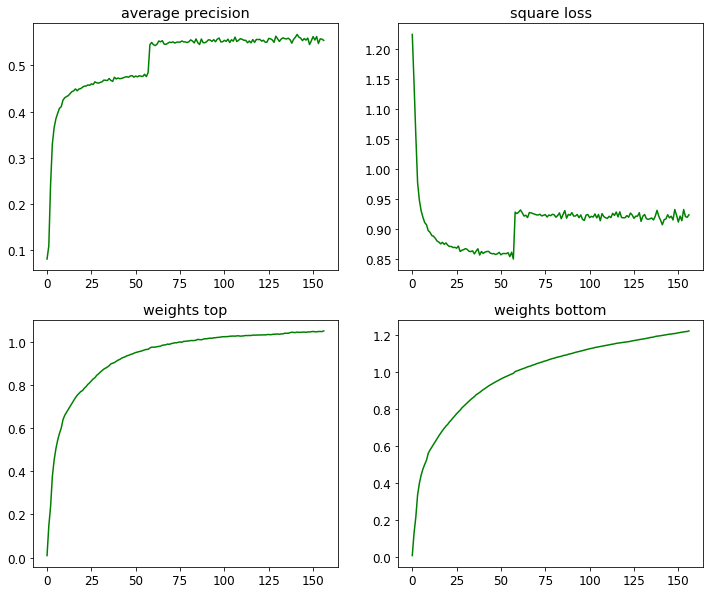

In [27]:
burnin=1
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(average_precision[burnin:],color='g')
ax2.set_title('square loss')
ax2.plot(square_error[burnin:],color='g')
ax3.set_title('weights top')
ax3.plot(weights_top[burnin:],color='g')
ax4.set_title('weights bottom')
ax4.plot(weights_bottom[burnin:],color='g')

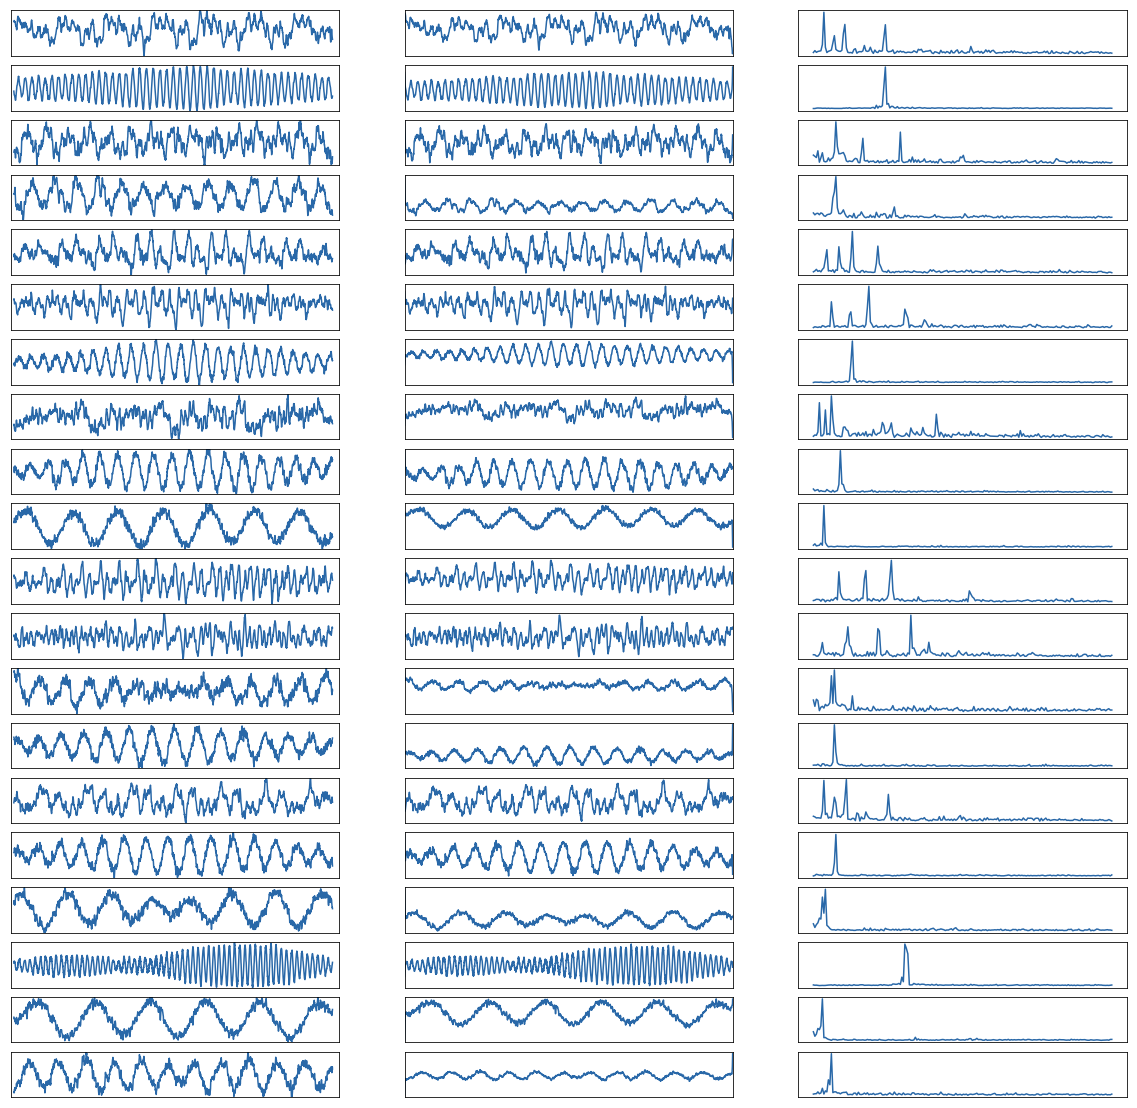

In [28]:
offset = 20
window = 2048
f, ax = plt.subplots(20,3, sharey=False)
f.set_figheight(20)
f.set_figwidth(20)
weights = w.eval(session=sess)
for i in range(20):
    ax[i,0].plot(weights[10:-10,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,0].set_xlim([-20,d+20])
    ax[i,0].set_ylim([np.min(weights[10:-10,i+offset]),np.max(weights[10:-10,i+offset])])
    ax[i,0].set_xticklabels([])
    ax[i,0].set_yticklabels([])
    ax[i,1].plot(weights[d/2-1024:d/2+1024,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,1].set_xticklabels([])
    ax[i,1].set_yticklabels([])
    ax[i,1].set_xlim([0,d])
    ax[i,2].plot(np.abs(fft(weights[:,i+offset]))[0:200], color=(41/255.,104/255.,168/255.))
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])
    
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [29]:
folder = 'mlp_small_log/'

weights = w.eval(session=sess)
coefficients = beta.eval(session=sess)

np.save(open(folder + 'w.npy','wb'),weights)
np.save(open(folder + 'beta.npy','wb'),coefficients)
np.save(open(folder + 'ap.npy','wb'),average_precision)
np.save(open(folder + 'loss.npy','wb'),square_error)
np.save(open(folder + 'wtop.npy','wb'),weights_top)
np.save(open(folder + 'wbot.npy','wb'),weights_bottom)

# MIREX evaluation

In [30]:
import mir_eval
def estimate(X,subdiv=50):
    return np.dot(X,w)

In [31]:
def estimate(X,subdiv=50):
    subset = X.shape[0]/subdiv
    Yhatbase = np.empty((X.shape[0],m))
    for j in range(subdiv):
        Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: X[subset*j:subset*(j+1)]})
        
    return Yhatbase

In [32]:
Xvalidation = np.zeros([50*len(train_data),d])
Yvalidation = np.zeros([50*len(train_data),m])
for i in range(len(train_data)):
    # 50 random samples from each recording
    s = np.random.randint(d/2,len(train_data[train_ids[i]][features])-d/2,size=100)
    for j in range(50):
        Xvalidation[50*i+j] = train_data[train_ids[i]][features][s[j]-d/2:s[j]+d/2]
        Xvalidation[50*i+j] /= np.linalg.norm(Xvalidation[50*i+j]) + 10e-6
        # label stuff that's on in the center of the window
        for label in train_data[train_ids[i]][labels][s[j]]:
            Yvalidation[50*i+j,label.data[1]] = 1

In [33]:
Yhattestbase = estimate(Xtest)
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
print average_precision_score(yflat, yhatflat)

0.5562686670365199


. . . . . 0.246


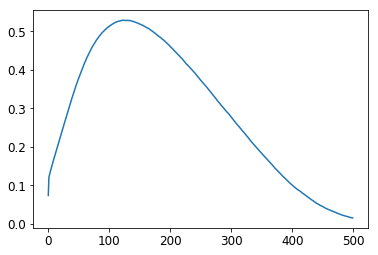

In [34]:
Yhatbase = estimate(Xvalidation)

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [35]:
Yhatbase = estimate(Xtest)

Yhat = Yhatbase>c
Yhatlist = []
Ytestlist = []
for i in range(len(Yhat)):
    fhat = []
    ftest = []
    for note in range(128):
        if Yhat[i][note] == 1:
            fhat.append(440.*2**((note - 69.)/12.))
        if Ytest[i][note] == 1:
            ftest.append(440.*2**((note - 69.)/12.))
    Yhatlist.append(np.array(fhat))
    Ytestlist.append(np.array(ftest))

In [36]:
P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
mir_eval.multipitch.metrics(np.arange(len(Ytestlist))/100.,Ytestlist,np.arange(len(Yhatlist))/100.,Yhatlist)

print P
print R
print Acc
print Etot
print Esub
print Emiss
print Efa

print '-----'

print cP
print cR
print cAcc
print cEtot
print cEsub
print cEmiss
print cEfa

0.519376530493
0.611253430924
0.3904163623082542
0.7690759377859103
0.1853156450137237
0.20343092406221408
0.3803293687099725
-----
0.563960041979
0.663723696249
0.4386299050728581
0.7166056724611162
0.13284537968892954
0.20343092406221408
0.3803293687099725


# Precision/Recall

In [37]:
fs = 44100
m = 128

composition = 2
            
# create the test set
Xtest = np.empty([7500,d])
Ytest = np.zeros([7500,m])
for i in range(1):
    for j in range(7500):
        index = fs+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[j] = test_data[test_ids[composition]][features][index:index+d]
        Xtest[j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[composition]][labels][index+d/2]:
            Ytest[7500*i + j,label.data[1]] = 1

In [38]:
print test_ids[composition]

1819


In [39]:
Yhattestbase = estimate(Xtest)
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.5193765304932562
0.6112534309240623
0.5615819446487486


0.5562686670365199


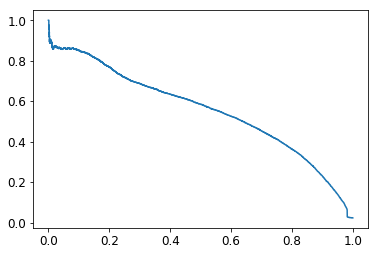

In [40]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

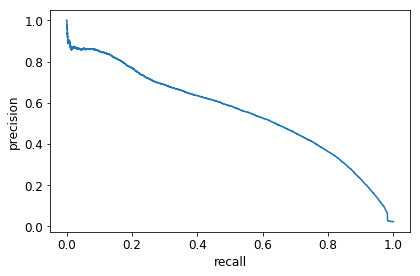

In [41]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(recall,precision)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

plt.tight_layout()
plt.savefig('mlp500_pr.eps',format='eps', dpi=1000)